# Capstone Project

## This notebook will be used to work on the Capstone project from Applied Data Science Capstone - Coursera

# Machine Learning as a tool to predict the severity of an accident: Case Study from Seattle (WA) 2004-2020 record

## Introduction to the project
According to the statistics by WHO (World Health Organization) (Feb, 2020):

Road traffic injuries are the leading cause of death for children and young adults aged 5-29 years.
Road traffic injuries cause considerable economic losses to individuals, their families, and to nations as a whole. These losses arise from the cost of treatment as well as lost productivity 
for those killed or disabled by their injuries, and for family members who need to take time off work or school to care for the injured. 

This, therefore, needs serious attention, as it concerns human lives which is irreplaceable. It is possible, thanks to machine learning, to predict the severity of car accidents as a  result of the complex interplay of multitudes of factors like weather, road condition, light condition, speeding etc. and also to identify which factors are more important. 
The information thus gathered can be used to take preventive measurements.

According to the National Safety Council, traffic collisions cause more than 40,000 deaths and injure thousands of people every year across the United States. 
These are not traffic accidents, but entirely preventable tragedies.

In order to reduce accidents, we need to predict it based on the external parameters. 

Since the accident occurs due to very many factors  (unsafe road infrastructure, light condition, vulnerable road users, speeding, driving under the influence of alcohol and other psychoactive substances, distracted driving, weather)  prediction of accidental severity is a challenge. Machine Learning is ideally suited here as this is a scientific approach for modelling and predicting the parameter of interest demanding only a low budget.


The current project attempts to apply a machine learning technique to predict the severity of the accident given the parameters as stated before using car collision data for the city of Seattle, USA.


## Business plan
The ability of emergency service to manage medical assets during an accident (i.e. ambulances, personnel, material,  ER and hospital beds) is a key feature for a positive outcome. Since resurces and assets are finite,
there is the need to be able to dispach the required vehicle/personnel in the measure that it is needed, providing the personnel both on the field and in a hospital with the best conditions to deal with the emergency
The tempestivity of the response and the rational use of the assets can be of paramount importance for the people involved and injured in an accident.

The model i propose here is based on the information that the witness of an accident can provide in a short amount of time to the emergency service, how the emergency service decides the severity of the accident, 
and decides to use its assets.

The number of information and the kind of information required for the model are kept at a minimum, to minimize the time spent communicating the information. Again, a prompt response can make the difference 
between life and death for an injured person.

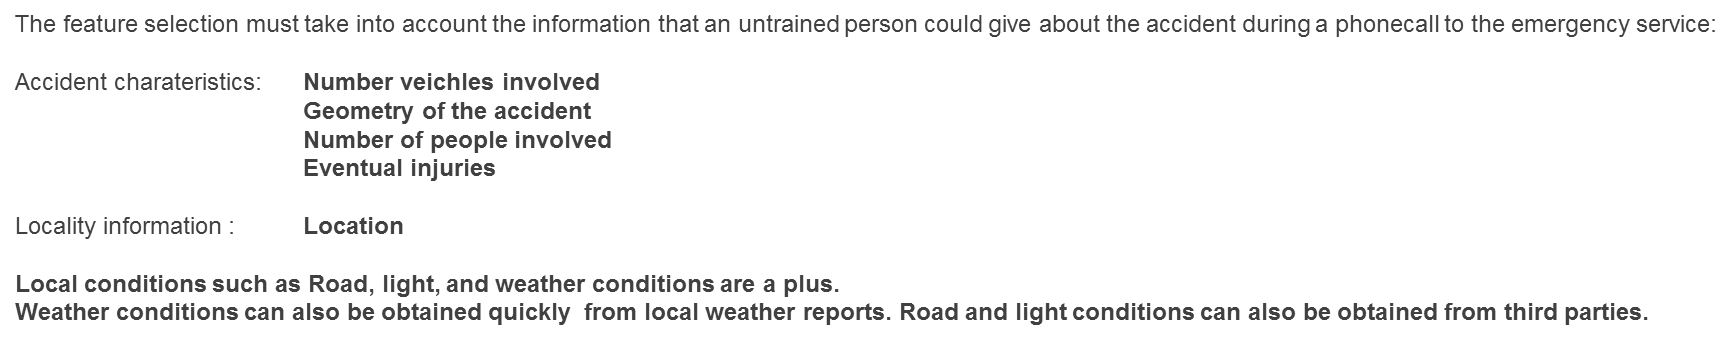

### Database and Methodologies

The DataBase used in this project is from the Seattle Department Of Transportation (SDOT) and can be downloaded here: 
https://www.kaggle.com/jonleon/seattle-sdot-collisions-data

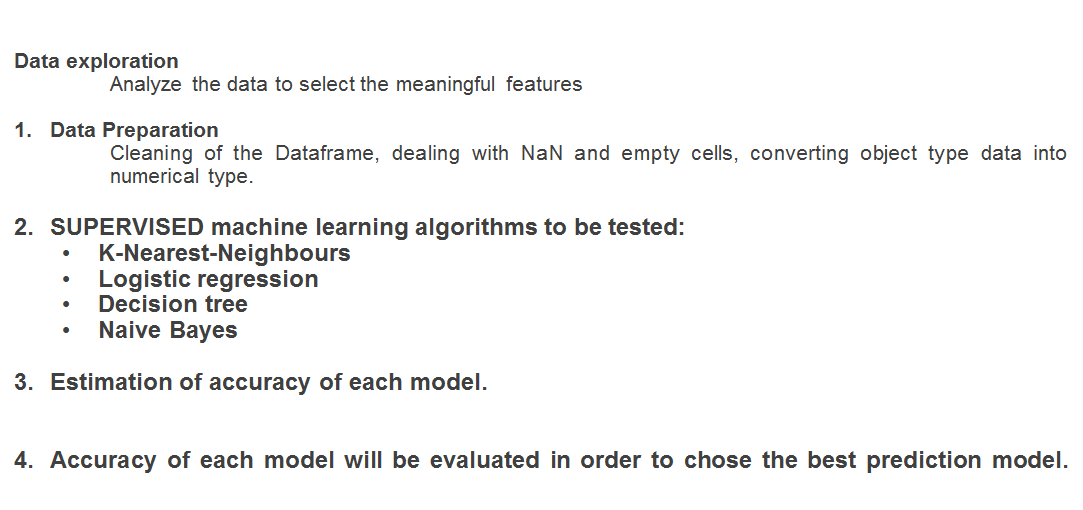

In [30]:
#import libraries and functions

import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import seaborn as sns
import pandas as pd
import numpy as np
import time
import matplotlib.ticker as ticker
from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix,precision_score, recall_score, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from pandas.plotting import register_matplotlib_converters
%matplotlib inline


In [31]:
#importing the dataset
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_3a2f64f5bc2a4d0f91365caaf695ca4e = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='PmV_MwoPWYlLM-WzSUHAVukTi3KNcJNl-dUVgALfu_rv',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

body = client_3a2f64f5bc2a4d0f91365caaf695ca4e.get_object(Bucket='machinelearningwithpythonassignme-donotdelete-pr-smaqudw1n8flfp',Key='Collisions.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_raw = pd.read_csv(body, parse_dates=["INCDATE"])
df_data_raw.head(1)


,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,-122.386772,47.56472,1,326234,327734,E984735,Matched,Intersection,31893.0,CALIFORNIA AVE SW AND SW GENESEE ST,...,Dry,Daylight,Y,NaN,NaN,2,Vehicle turning left hits pedestrian,0,0,N


In [6]:
df_data_raw.shape

(221266, 40)

In [7]:
df_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221266 entries, 0 to 221265
Data columns (total 40 columns):
 #   Column           Non-Null Count   Dtype              
---  ------           --------------   -----              
 0   X                213797 non-null  float64            
 1   Y                213797 non-null  float64            
 2   OBJECTID         221266 non-null  int64              
 3   INCKEY           221266 non-null  int64              
 4   COLDETKEY        221266 non-null  int64              
 5   REPORTNO         221266 non-null  object             
 6   STATUS           221266 non-null  object             
 7   ADDRTYPE         217554 non-null  object             
 8   INTKEY           71823 non-null   float64            
 9   LOCATION         216680 non-null  object             
 10  EXCEPTRSNCODE    100863 non-null  object             
 11  EXCEPTRSNDESC    11775 non-null   object             
 12  SEVERITYCODE     221265 non-null  object             
 13 

# Dataframe exploration

First, we need to observe what information are present in the Dataframe, and rationalize about which of these information are of importance
for our prediction model and can be easily assessed and communicated, by an untrained witness of the accident, to the emergency services.

- Severity code: it is our target
- X and Y : geographical information, the witness could simply inform the address, and the emergency service system could automatically transform that in X and Y coordinates
- ADDRTYPE: whether it is an intersection or a block, easy to assess and communicate
- COLLISIONTYPE: geometry of the collision, relatively easy to assess and communicate
- PERSONCOUNT: number of people involved. Can be ard to assess in case of a high number of people
- PEDCOUNT: number of people involves. Can be not trivial to assess.
- VEHCOUNT: number of involved vehicles. Can be hard to assess in cas of a high number of vehicles
- INJURIES, SERIOUSINJURIES, FATALITIES: number of injuries, gravity of the injuries, and eventual fatalities. Can be hard to assess for an untrained witness. number of fatalities cases are directly linked to SEVERITYCODE 4. For an untrained person it can be difficult to distinguish among injuries and serious injuries. We will keep only INJURIES as a feature.
- INCDATE, INCDTTM: date and time of the accident. Can be calculated automatically by the system at the time of the call 
- ROADCOND, LIGHTCOND, WEATHER: conditions of the road, illumination, and weather. Can be no trivial to assess an communicate. Weather information can be obtained almost in real time automatically from local weather services.
- UNDERINFL: whether one or more involved people were driving under the influence. Hard to assess by an untrained witness.
- SPEEDING : whether one or more vehicles was exceeding the speed limit at the time of the incident. Hard to assess by an untrained witness.
- HITPARKEDCAR: whether a parked car is involved. can be difficult to assess in complex accident involving numerous vehicles.
#### Information that can be too hard to assess by an untrained witness will not be considered for the feature list of the model, as are all the columns with desctriptive text (such as SEVERITYDESC).

### SEVERETY CODE of accidents

In [32]:
df_data_raw['SEVERITYCODE'].value_counts(normalize=True, dropna=False).round(5)

1      0.62136
2      0.26528
0      0.09778
2b     0.01400
3      0.00158
NaN    0.00000
Name: SEVERITYCODE, dtype: float64

In [33]:
#replacing NaN values with 0
df_data_raw['SEVERITYCODE'].replace('0', np.nan, inplace=True)

In [34]:
df_data_raw.dropna(axis=0, how='any',thresh=None, subset=['SEVERITYCODE'], inplace=True)

We can replace the SEVERITYCODE values for some more easy to handle (changing 2b to 3 and 3 to 4)

In [35]:

#replacing the values of the severitycode 
df_data_raw['SEVERITYCODE'].replace('3', '4', inplace=True)
df_data_raw['SEVERITYCODE'].replace('2b', '3', inplace=True)

In [36]:
#cast severitycode as integer
df_data_raw['SEVERITYCODE'] =  df_data_raw['SEVERITYCODE'].astype('int64')

Text(0.5, 1.0, 'SEVERITY COUNT')

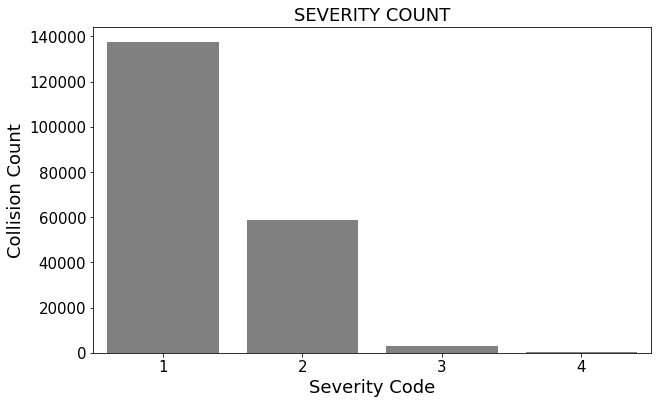

In [37]:
fig, ax = plt.subplots(figsize=(10,6))
sns.countplot(df_data_raw["SEVERITYCODE"], color = 'grey')
ax.set_xlabel('Severity Code', fontsize=18)
ax.tick_params(axis="x", labelsize=15)
ax.tick_params(axis="y", labelsize=15)
ax.set_ylabel('Collision Count', fontsize=18)
plt.title("SEVERITY COUNT", fontsize=18)

### Extracting information  for Year, Month and Day

In [38]:
df_data_raw['INCDTTM'] = pd.to_datetime(df_data_raw['INCDTTM'], errors='coerce')

In [39]:
df_data_raw["MONTH"] = df_data_raw["INCDATE"].dt.month
df_data_raw["YEAR"] = df_data_raw["INCDATE"].dt.year
df_data_raw["DAY"] = df_data_raw["INCDATE"].dt.day
df_data_raw['WEEKDAY'] = df_data_raw['INCDTTM'].dt.weekday
df_data_raw['Hour']=df_data_raw['INCDTTM'].dt.hour

Text(0.5, 1.0, 'Collision count per Year')

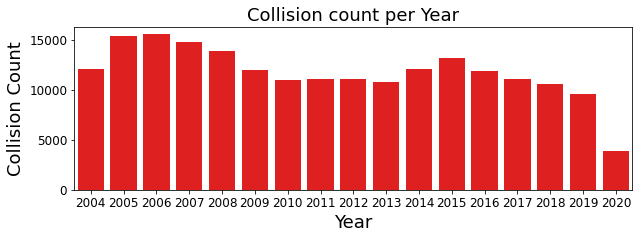

In [40]:
fig, ax = plt.subplots(figsize=(10,3))
sns.countplot(df_data_raw["YEAR"], color='red')
ax.set_xlabel('Year', fontsize=18)
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12)
ax.set_ylabel('Collision Count', fontsize=18)
plt.title("Collision count per Year", fontsize=18)

No clear tren in the number of accidents per year

Text(0.5, 1.0, 'Collision count per Month')

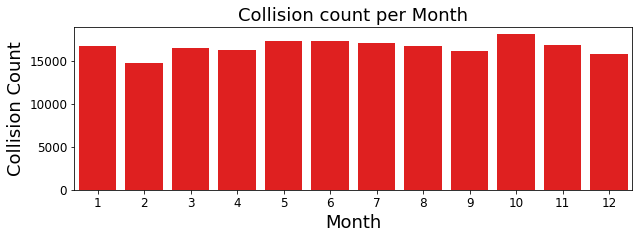

In [12]:
fig, ax = plt.subplots(figsize=(10,3))
sns.countplot(df_data_raw["MONTH"], color='red')
ax.set_xlabel('Month', fontsize=18)
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12)
ax.set_ylabel('Collision Count', fontsize=18)
plt.title("Collision count per Month", fontsize=18)

No clear trend in the number of accidents in the months of the year

Text(0.5, 1.0, 'Collision count per Day of the month')

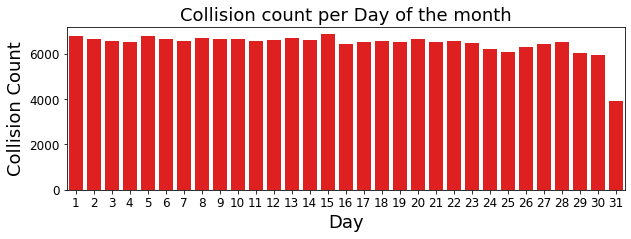

In [18]:
fig, ax = plt.subplots(figsize=(10,3))
sns.countplot(df_data_raw["DAY"], color='red')
ax.set_xlabel('Day', fontsize=18)
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12)
ax.set_ylabel('Collision Count', fontsize=18)
plt.title("Collision count per Day of the month", fontsize=18)

No clear trend in the number of accidents in the days of the month. Lower values for day 31 are explained by the fact that only half of the months in a year have 31 days.
We can therefore assume that year, month and day have no influence on the number of accidents.


Text(0.5, 1.0, 'Collision count Weekday')

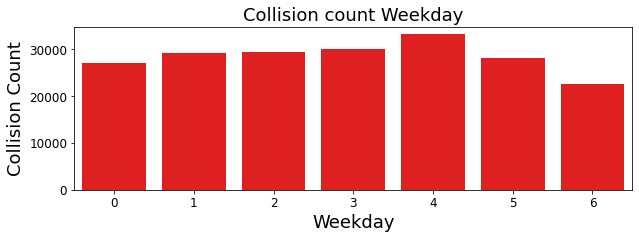

In [25]:
fig, ax = plt.subplots(figsize=(10,3))
sns.countplot(df_data_raw["WEEKDAY"], color='red')
ax.set_xlabel('Weekday', fontsize=18)
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12)
ax.set_ylabel('Collision Count', fontsize=18)
plt.title("Collision count Weekday", fontsize=18)

There is a slight decrease in the number of accident during the weekend (weekdays 5 and 6), as can be expected. otherwise there is no strong correlatioin between the weekday and the number of accidents.


We need now to check the variation in number of accidents during the hours of the day


In [20]:
df_data_raw['Hour'].value_counts()

0     34900
17    13319
16    12447
15    11827
14    10888
12    10653
13    10468
18    10044
8      8766
11     8391
9      8246
10     7648
19     7444
7      6729
20     6428
21     5771
22     5610
23     4749
2      3722
1      3540
6      3316
3      1730
5      1721
4      1273
Name: Hour, dtype: int64

the high number of accidents at 0h are the sum of real accidents and accidents with unknown time. we can eliminate these datapoints, otherwise the model will be affected by these artifacts

In [41]:
df_data_raw.drop(df_data_raw.loc[df_data_raw['Hour'] == 0].index, inplace = True)

In [27]:
df_data_raw['Hour'].value_counts()

17    13319
16    12447
15    11827
14    10888
12    10653
13    10468
18    10044
8      8766
11     8391
9      8246
10     7648
19     7444
7      6729
20     6428
21     5771
22     5610
23     4749
2      3722
1      3540
6      3316
3      1730
5      1721
4      1273
Name: Hour, dtype: int64

Text(0.5, 1.0, 'Collision count per Hour of the day')

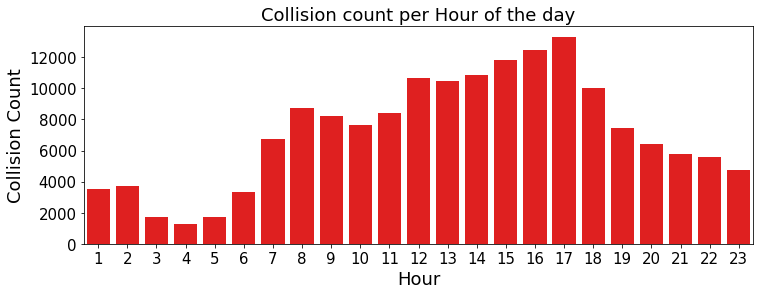

In [12]:
fig, ax = plt.subplots(figsize=(12,4))
sns.countplot(df_data_raw["Hour"], color='red')
ax.set_xlabel('Hour', fontsize=18)
ax.tick_params(axis="x", labelsize=15)
ax.tick_params(axis="y", labelsize=15)
ax.set_ylabel('Collision Count', fontsize=18)
plt.title("Collision count per Hour of the day", fontsize=18)

Now we see better that there is a relationship between the number of accidents and the hour of the day. More accidents happen during the day than at night, with a peak at 17:00 (supposedly when people leave work ___en masse___).
As there is a variation in number of accidents during different hours of the day, we need to consider this in our prediction model, and turn this into a feature.

### Injuries

In [88]:
df_data_raw['INJURIES'].value_counts()

0     112583
1      39876
2       8936
3       2298
4        660
5        231
6         81
7         31
8         11
9          8
10         6
11         5
78         1
15         1
13         1
12         1
Name: INJURIES, dtype: int64

Text(0.5, 1.0, 'Injuries count per accident')

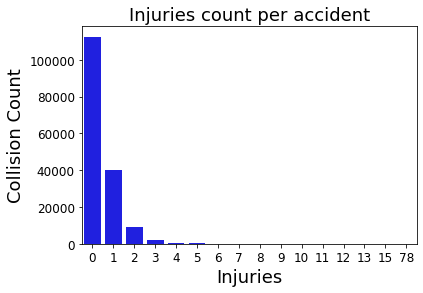

In [90]:
fig, ax = plt.subplots(figsize=(6,4))
sns.countplot(df_data_raw["INJURIES"], color='blue')
ax.set_xlabel('Injuries', fontsize=18)
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12)
ax.set_ylabel('Collision Count', fontsize=18)
plt.title("Injuries count per accident", fontsize=18)

We see that the majority of the accidents involve 2 or less injuries. This means that a witness could quickly asses the number and relay the information to the emergency services wia phone.

In [ ]:
df_data_raw['SERIOUSINJURIES'].value_counts()

Text(0.5, 1.0, 'Serious injuries per collision')

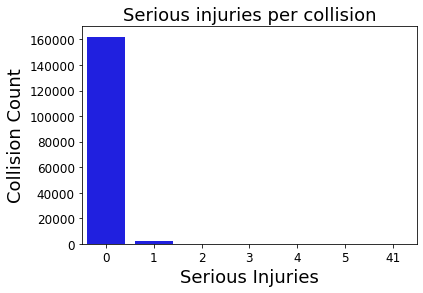

In [20]:
fig, ax = plt.subplots(figsize=(6,4))
sns.countplot(df_data_raw["SERIOUSINJURIES"], color='blue')
ax.set_xlabel('Serious Injuries', fontsize=18)
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12)
ax.set_ylabel('Collision Count', fontsize=18)
plt.title("Serious injuries per collision", fontsize=18)

In [21]:
df_data_raw['FATALITIES'].value_counts()

0    164455
1       259
2        12
3         2
5         1
4         1
Name: FATALITIES, dtype: int64

Text(0.5, 1.0, 'Fatalities per collision')

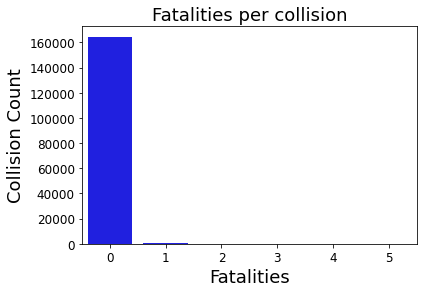

In [23]:
fig, ax = plt.subplots(figsize=(6,4))
sns.countplot(df_data_raw["FATALITIES"], color='blue')
ax.set_xlabel('Fatalities', fontsize=18)
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12)
ax.set_ylabel('Collision Count', fontsize=18)
plt.title("Fatalities per collision", fontsize=18)

 ### Vehicle count

In [38]:
df_data_raw['VEHCOUNT'].value_counts()

2     126692
1      23741
3      11312
4       2094
5        465
0        228
6        124
7         40
8         15
9          9
11         5
10         2
15         1
13         1
12         1
Name: VEHCOUNT, dtype: int64

Text(0.5, 1.0, 'Vehicle count per collision')

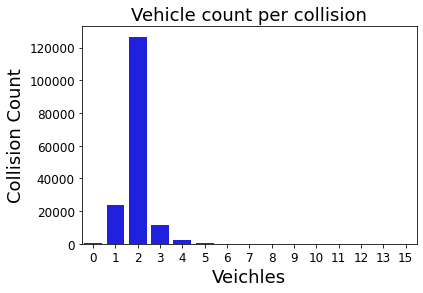

In [18]:
fig, ax = plt.subplots(figsize=(6,4))
sns.countplot(df_data_raw["VEHCOUNT"], color='blue')
ax.set_xlabel('Veichles', fontsize=18)
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12)
ax.set_ylabel('Collision Count', fontsize=18)
plt.title("Vehicle count per collision", fontsize=18)

We see that the vast majority of the accident involves two veichles, and that rarely goes above 3. 
We can imagine that a witness of the accident would be able to easly assess the number of the vehicles and quickly inform the emergency services

# Dataframe preparation

In [42]:
#drop clearly unnecessary columns
df_data_1 = df_data_raw.drop(['OBJECTID','SEVERITYDESC','EXCEPTRSNCODE', 'STATUS', 'UNDERINFL','EXCEPTRSNDESC','REPORTNO','INCKEY',
                              'LOCATION','COLDETKEY', 'INTKEY', 'ST_COLDESC', 'CROSSWALKKEY', 'SEGLANEKEY','JUNCTIONTYPE', 
                              'UNDERINFL', 'INATTENTIONIND', 'PEDROWNOTGRNT', 'SDOTCOLNUM', 'SPEEDING', 'PEDCOUNT'], axis =1)
df_data_1.head()

,X,Y,ADDRTYPE,SEVERITYCODE,COLLISIONTYPE,PERSONCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,...,WEATHER,ROADCOND,LIGHTCOND,ST_COLCODE,HITPARKEDCAR,MONTH,YEAR,DAY,WEEKDAY,Hour
0,-122.386772,47.564720,Intersection,2,Pedestrian,2,0,1,1,0,...,Clear,Dry,Daylight,2,N,11,2019,20,2,10
1,-122.341806,47.686934,Intersection,2,Angles,4,0,2,2,0,...,Raining,Wet,Dark - Street Lights On,10,N,11,2019,18,0,17
2,-122.374899,47.668666,Block,1,Sideswipe,4,0,3,0,0,...,Clear,Dry,Daylight,11,N,2,2020,20,3,8
6,-122.323569,47.722577,Block,1,Other,2,0,2,0,0,...,Clear,Dry,Dark - Street Lights On,50,N,6,2019,16,6,1
7,-122.330904,47.558650,Intersection,1,Other,1,0,1,0,0,...,Clear,Dry,Daylight,50,N,3,2013,28,3,14


In [46]:
df_data_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199630 entries, 0 to 221265
Data columns (total 20 columns):
 #   Column           Non-Null Count   Dtype              
---  ------           --------------   -----              
 0   X                194228 non-null  float64            
 1   Y                194228 non-null  float64            
 2   ADDRTYPE         197699 non-null  object             
 3   SEVERITYCODE     199630 non-null  object             
 4   COLLISIONTYPE    194765 non-null  object             
 5   PERSONCOUNT      199630 non-null  int64              
 6   PEDCOUNT         199630 non-null  int64              
 7   PEDCYLCOUNT      199630 non-null  int64              
 8   VEHCOUNT         199630 non-null  int64              
 9   INJURIES         199630 non-null  int64              
 10  SERIOUSINJURIES  199630 non-null  int64              
 11  FATALITIES       199630 non-null  int64              
 12  INCDATE          199630 non-null  datetime64[ns, UTC]
 13 

### NaN values
we need to check if and how many NaN values are present in each of the columns that we have chosen as feature and target.

In [127]:
#check for NaN values
print("The column 'Y' has " + str(df_data_1['Y'].isnull().sum()) + " NaN values")
print("The column 'X' has " + str(df_data_1['X'].isnull().sum()) + " NaN values")
print("The column 'PERSONCOUNT' has " + str(df_data_1['PERSONCOUNT'].isnull().sum()) + " NaN values")
print("The column 'PEDCOUNT' has " + str(df_data_1['PEDCOUNT'].isnull().sum()) + " NaN values")
print("The column 'VEHCOUNT' has " + str(df_data_1['VEHCOUNT'].isnull().sum()) + " NaN values")
print("The column 'INCDATE' has " + str(df_data_1['INCDATE'].isnull().sum()) + " NaN values")
print("The column 'ST_COLCODE' has " + str(df_data_1['ST_COLCODE'].isnull().sum()) + " NaN values")
print("The column 'WEATHER' has " + str(df_data_1['WEATHER'].isnull().sum()) + " NaN values")
print("The column 'ROADCOND' has " + str(df_data_1['ROADCOND'].isnull().sum()) + " NaN values")
print("The column 'LIGHTCOND' has " + str(df_data_1['LIGHTCOND'].isnull().sum()) + " NaN values")
print("The column 'COLLISIONTYPE' has " + str(df_data_1['COLLISIONTYPE'].isnull().sum()) + " NaN values")
print("The column 'ADDRTYPE' has " + str(df_data_1['ADDRTYPE'].isnull().sum()) + " NaN values")

The column 'Y' has 4360 NaN values
The column 'X' has 4360 NaN values
The column 'PERSONCOUNT' has 0 NaN values
The column 'PEDCOUNT' has 0 NaN values
The column 'VEHCOUNT' has 0 NaN values
The column 'INCDATE' has 0 NaN values
The column 'ST_COLCODE' has 18 NaN values
The column 'WEATHER' has 193 NaN values
The column 'ROADCOND' has 124 NaN values
The column 'LIGHTCOND' has 282 NaN values
The column 'COLLISIONTYPE' has 21 NaN values
The column 'ADDRTYPE' has 1571 NaN values


We need to deal with NaN values in the columns. 

We can sobstitute the NaN values in the columns 'WEATHER', 'ROADCOND', 'LIGHTCOND' with "unknown/0" (that will later transformed into a number by the '.get_dummies' function).

We can drop the lines that have X, Y or COLLISIONTYPE, or ST_COLCODE with NaN values, as it is fundamental for the scope of this analysis to know the position and the type of the accident. The dropped lines represent ca. 0.38% of the dataset.

In [43]:
#sustituting empty strings with NaN
nan_value= float("NaN")
df_data_1.replace(" ", nan_value, inplace= True)

#dropping lines with NaN in at least one of the  feature columns
df_data_1 = df_data_1[np.isfinite(df_data_1['X'])]
df_data_1 = df_data_1[np.isfinite(df_data_1['Y'])]


#df_data_1 = df_data_1[np.isfinite(df_data_1['COLLISIONTYPE'])]
#df_data_1 = df_data_1[np.isfinite(df_data_1['ST_COLCODE'])]
#df_data_1 = df_data_1[np.isfinite(df_data_1['ADDRTYPE'])]


#substituting NaN values with '0' in the feature columns WEATHER, ROADCOND, LIGHTCOND
df_data_1 = df_data_1.fillna('0')


In [17]:
#check for NaN values
print("The column 'Y' has " + str(df_data_1['Y'].isnull().sum()) + " NaN values")
print("The column 'X' has " + str(df_data_1['X'].isnull().sum()) + " NaN values")
print("The column 'PERSONCOUNT' has " + str(df_data_1['PERSONCOUNT'].isnull().sum()) + " NaN values")
print("The column 'PEDCOUNT' has " + str(df_data_1['PEDCOUNT'].isnull().sum()) + " NaN values")
print("The column 'VEHCOUNT' has " + str(df_data_1['VEHCOUNT'].isnull().sum()) + " NaN values")
print("The column 'INCDATE' has " + str(df_data_1['INCDATE'].isnull().sum()) + " NaN values")
print("The column 'ST_COLCODE' has " + str(df_data_1['ST_COLCODE'].isnull().sum()) + " NaN values")
print("The column 'WEATHER' has " + str(df_data_1['WEATHER'].isnull().sum()) + " NaN values")
print("The column 'ROADCOND' has " + str(df_data_1['ROADCOND'].isnull().sum()) + " NaN values")
print("The column 'LIGHTCOND' has " + str(df_data_1['LIGHTCOND'].isnull().sum()) + " NaN values")
print("The column 'COLLISIONTYPE' has " + str(df_data_1['COLLISIONTYPE'].isnull().sum()) + " NaN values")
print("The column 'ADDRTYPE' has " + str(df_data_1['ADDRTYPE'].isnull().sum()) + " NaN values")

The column 'Y' has 0 NaN values
The column 'X' has 0 NaN values
The column 'PERSONCOUNT' has 0 NaN values
The column 'PEDCOUNT' has 0 NaN values
The column 'VEHCOUNT' has 0 NaN values
The column 'INCDATE' has 0 NaN values
The column 'ST_COLCODE' has 0 NaN values
The column 'WEATHER' has 0 NaN values
The column 'ROADCOND' has 0 NaN values
The column 'LIGHTCOND' has 0 NaN values
The column 'COLLISIONTYPE' has 0 NaN values
The column 'ADDRTYPE' has 0 NaN values


## We look among the potential features how the values are distributed, and how we can simplify the classes.

### Light Condition

In [66]:
df_data_1['LIGHTCOND'].value_counts()


Daylight                    101271
Dark - Street Lights On      39113
Unknown                      10164
Dusk                          5044
Dawn                          2173
Dark - No Street Lights       1217
Dark - Street Lights Off       936
0                              272
Other                          161
Dark - Unknown Lighting         19
Name: LIGHTCOND, dtype: int64

Text(0.5, 1.0, 'Collision count per light condition')

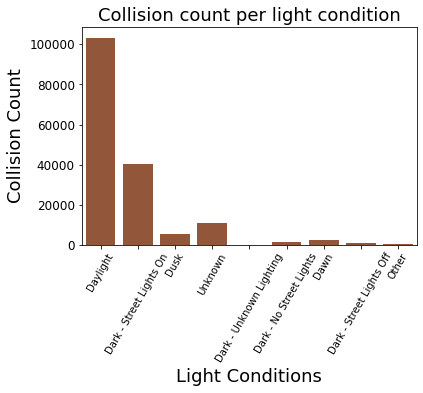

In [28]:
fig, ax = plt.subplots(figsize=(6,4))
sns.countplot(df_data_raw["LIGHTCOND"], color= 'sienna')
ax.set_xlabel('Light Conditions', fontsize=18)
ax.tick_params(axis="x", labelsize=10, rotation=60)
ax.tick_params(axis="y", labelsize=12)
ax.set_ylabel('Collision Count', fontsize=18)
plt.title("Collision count per light condition", fontsize=18)

Most of the accidents happen during daylight or in the dark with street lights on. 
We can group the light conditions in 3 categories: 'Daylight', 'Dark-lights on', 'other'

In [44]:
df_data_1['LIGHTCOND'].replace(to_replace=['Daylight','Dark - Street Lights On'], value=[0,1],inplace=True)
df_data_1['LIGHTCOND'].replace(to_replace=['0','Unknown', 'Dusk', 'Dawn','Other', 
                                           'Dark - No Street Lights','Dark - Street Lights Off', 
                                           'Dark - Unknown Lighting'], value=[2,2,2,2,2,2,2,2], inplace=True)
                                           
df_data_1['LIGHTCOND'].value_counts()

0    101271
1     39113
2     19986
Name: LIGHTCOND, dtype: int64

### Road Condition

In [21]:
df_data_1['ROADCOND'].value_counts()

Dry               125681
Wet                47290
Unknown            13892
0                   4822
Ice                 1198
Snow/Slush           999
Other                121
Standing Water       106
Sand/Mud/Dirt         66
Oil                   53
Name: ROADCOND, dtype: int64

Text(0.5, 1.0, 'Collision count per road condition')

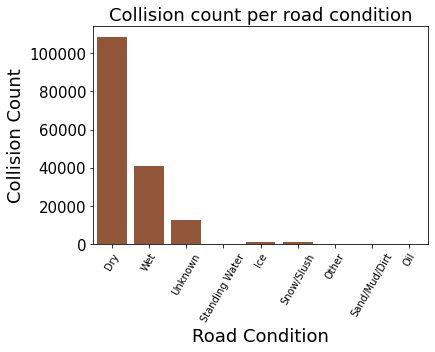

In [36]:
fig, ax = plt.subplots(figsize=(6,4))
sns.countplot(df_data_raw["ROADCOND"], color= 'sienna')
ax.set_xlabel('Road Condition', fontsize=18)
ax.tick_params(axis="x", labelsize=10, rotation=60)
ax.tick_params(axis="y", labelsize=15)
ax.set_ylabel('Collision Count', fontsize=18)
plt.title("Collision count per road condition", fontsize=18)

Most of the accidents happen with wet or dry roads. We can group the road conditions in 3 categories: 'Wet', 'Dry', 'other'.

In [45]:
df_data_1['ROADCOND'].replace(to_replace=['Wet','Dry'], value=[0,1],inplace=True)
df_data_1['ROADCOND'].replace(to_replace=['0','Unknown', 'Snow/Slush', 'Ice','Other', 
                                           'Sand/Mud/Dirt','Standing Water', 'Oil'], value=[2,2,2,2,2,2,2,2], inplace=True)
                                           
df_data_1['ROADCOND'].value_counts()

1    106664
0     39964
2     13742
Name: ROADCOND, dtype: int64

### Weather

In [105]:
df_data_1['WEATHER'].value_counts()

Clear                       95325
Raining                     27803
Overcast                    23582
Unknown                     11444
Snowing                       748
Other                         630
Fog/Smog/Smoke                490
0                             184
Sleet/Hail/Freezing Rain       86
Blowing Sand/Dirt              45
Severe Crosswind               23
Partly Cloudy                   9
Blowing Snow                    1
Name: WEATHER, dtype: int64

Text(0.5, 1.0, 'Collision count per Weather condition')

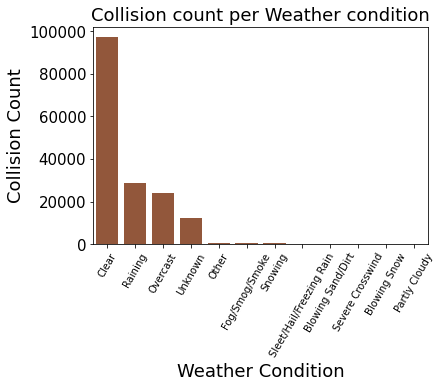

In [39]:
fig, ax = plt.subplots(figsize=(6,4))
sns.countplot(df_data_raw["WEATHER"], color= 'sienna')
ax.set_xlabel('Weather Condition', fontsize=18)
ax.tick_params(axis="x", labelsize=10, rotation=60)
ax.tick_params(axis="y", labelsize=15)
ax.set_ylabel('Collision Count', fontsize=18)
plt.title("Collision count per Weather condition", fontsize=18)

Most of the accidents happen with clear  weather. We can group the road conditions in 2 categories: 'Clear' and 'Not Clear'

In [46]:
df_data_1['WEATHER'].replace(to_replace=['Clear'], value=[1],inplace=True)
df_data_1['WEATHER'].replace(to_replace=['0','Overcast', 'Raining', '0','Other', 
                                           'Unknown','Snowing', 'Fog/Smog/Smoke','Sleet/Hail/Freezing Rain',
                                         'Blowing Sand/Dirt', 'Partly Cloudy', 'Severe Crosswind','Blowing Snow' ], 
                             value=[2,2,2,2,2,2,2,2,2,2,2,2,2], inplace=True)
                                           
df_data_1['WEATHER'].value_counts()

1    95325
2    65045
Name: WEATHER, dtype: int64

In [108]:
df_data_1['COLLISIONTYPE'].value_counts()

Parked Car    38263
Angles        30488
Rear Ended    28661
Other         18726
Sideswipe     15799
Left Turn     12074
Pedestrian     6685
Cycles         5239
Right Turn     2554
Head On        1860
0                21
Name: COLLISIONTYPE, dtype: int64

Text(0.5, 1.0, 'Collision count per typpe')

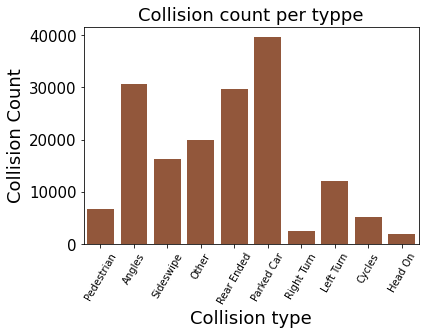

In [41]:
fig, ax = plt.subplots(figsize=(6,4))
sns.countplot(df_data_raw["COLLISIONTYPE"], color= 'sienna')
ax.set_xlabel('Collision type', fontsize=18)
ax.tick_params(axis="x", labelsize=10, rotation=60)
ax.tick_params(axis="y", labelsize=15)
ax.set_ylabel('Collision Count', fontsize=18)
plt.title("Collision count per typpe", fontsize=18)

The number of accidents relative to the collision type is more distributed, therefore we keep all the types separated. We convert the classes 
into numbers from 1 to 11 to ease the calculations of the prediction model

In [47]:
df_data_1['COLLISIONTYPE'].replace(to_replace=['Angles', 'Sideswipe','Parked Car', 'Other', 'Cycles',
                                              'Rear Ended', 'Head On', '0', 'Left Turn', 'Pedestrian',
                                              'Right Turn'], value=[1,2,3,4,5,6,7,8,9,10,11],inplace=True)


### Address Type

In [152]:
df_data_1['ADDRTYPE'].value_counts()

Block           127219
Intersection     67009
Name: ADDRTYPE, dtype: int64

In [48]:
df_data_1['ADDRTYPE'].replace(to_replace=['Block', 'Intersection'], value=[1,2],inplace=True)
df_data_1['ADDRTYPE'].value_counts()

1    103929
2     56441
Name: ADDRTYPE, dtype: int64

### Hit parked car


In [31]:
df_data_1['HITPARKEDCAR'].value_counts()

N    157881
Y      6849
Name: HITPARKEDCAR, dtype: int64

Text(0.5, 1.0, 'Collision count per typpe')

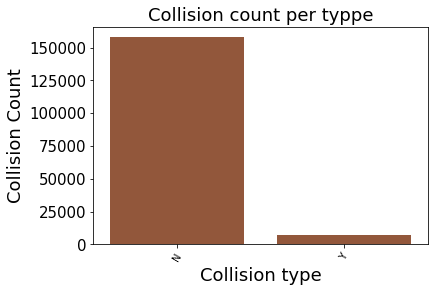

In [44]:
fig, ax = plt.subplots(figsize=(6,4))
sns.countplot(df_data_raw["HITPARKEDCAR"], color= 'sienna')
ax.set_xlabel('Collision type', fontsize=18)
ax.tick_params(axis="x", labelsize=10, rotation=60)
ax.tick_params(axis="y", labelsize=15)
ax.set_ylabel('Collision Count', fontsize=18)
plt.title("Collision count per typpe", fontsize=18)

In [49]:
df_data_1['HITPARKEDCAR'].replace(to_replace=['N', 'Y'], value=[1,2],inplace=True)
df_data_1['HITPARKEDCAR'].value_counts()

1    153729
2      6641
Name: HITPARKEDCAR, dtype: int64

### Injuries

We cannot assume that an untrained witness would be able to distinguish at a glance non-serious injuries from serious injuries. We can sum the two columns
to create a TOTALINJURIES column

In [54]:
df_data_1['TOTALINJURIES']=df_data_1['INJURIES'] + df_data_1['SERIOUSINJURIES']

In [55]:
df_data_1['TOTALINJURIES'].value_counts()

0      109108
1       37300
2       10238
3        2500
4         783
5         244
6         107
7          42
8          20
9          11
10          6
11          4
12          2
13          2
20          1
15          1
119         1
Name: TOTALINJURIES, dtype: int64

Text(0.5, 1.0, 'Total injuries')

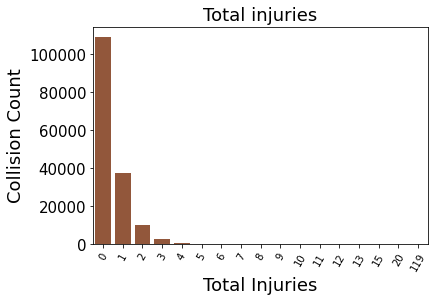

In [60]:
fig, ax = plt.subplots(figsize=(6,4))
sns.countplot(df_data_1["TOTALINJURIES"], color= 'sienna')
ax.set_xlabel('Total Injuries', fontsize=18)
ax.tick_params(axis="x", labelsize=10, rotation=60)
ax.tick_params(axis="y", labelsize=15)
ax.set_ylabel('Collision Count', fontsize=18)
plt.title("Total injuries", fontsize=18)

In [62]:
df_data_1 =df_data_1.drop(['INJURIES'], axis =1)

### Heatmap for cross-correlation 

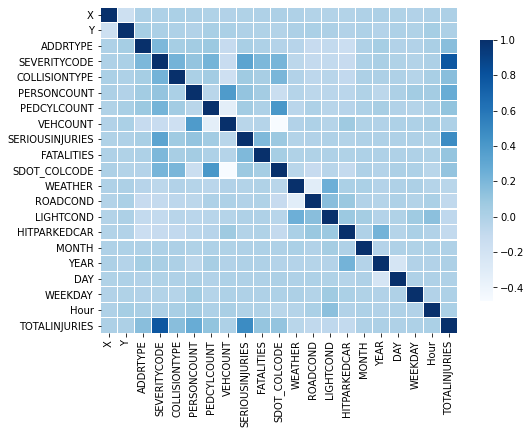

In [79]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(df_data_1.corr(), cmap= 'Blues', linewidth=0.3, cbar_kws={"shrink": .8})
plt.show()

As expected, there is a very strong correlation between injuries and severity code. 

### Feature selection for the prediction model

In [80]:
feature = df_data_1[['X','Y','VEHCOUNT','ST_COLCODE','WEATHER','ROADCOND','LIGHTCOND',
                     'COLLISIONTYPE', 'ADDRTYPE', 'Hour', 'TOTALINJURIES']]

In [81]:
X = feature
y = df_data_1['SEVERITYCODE'].values

In [67]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160370 entries, 0 to 221265
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   X              160370 non-null  float64
 1   Y              160370 non-null  float64
 2   VEHCOUNT       160370 non-null  int64  
 3   ST_COLCODE     160370 non-null  object 
 4   WEATHER        160370 non-null  int64  
 5   ROADCOND       160370 non-null  int64  
 6   LIGHTCOND      160370 non-null  int64  
 7   COLLISIONTYPE  160370 non-null  int64  
 8   ADDRTYPE       160370 non-null  int64  
 9   Hour           160370 non-null  int64  
 10  TOTALINJURIES  160370 non-null  int64  
dtypes: float64(2), int64(8), object(1)
memory usage: 19.7+ MB


### Train Test Split

In [68]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=1)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (112259, 11) (112259,)
Test set: (48111, 11) (48111,)


### Normalization

In [69]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0]

array([-1.88066242, -0.96558362, -1.69945832, -1.40078313, -0.82604471,
        0.29455043, -0.697964  ,  2.15708212,  1.35697243, -0.67150564,
        0.66465427])

# MODELING

## KKN

In [71]:
#check which K is the best for the model
Ks = 25
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ks=[]
mean_accuracy=[]
ConfustionMx = [];
for n in range(1,Ks):
    
 
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat_knn=neigh.predict(X_test)
    ks.append(n)
    
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat_knn)
    mean_accuracy.append(mean_acc) 
    
    std_acc[n-1]=np.std(yhat_knn==y_test)/np.sqrt(yhat_knn.shape[0])

mean_acc

array([0.97258423, 0.97102534, 0.97609694, 0.97295837, 0.97561888,
       0.9726258 , 0.97426784, 0.97102534, 0.97231402, 0.96967429,
       0.9707967 , 0.96788676, 0.96909231, 0.96645258, 0.96734634,
       0.96470662, 0.96570431, 0.96298144, 0.96395835, 0.96150568,
       0.96225395, 0.96027935, 0.96108998, 0.95892831])

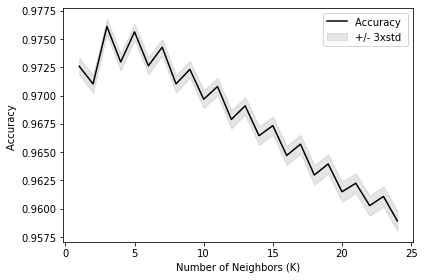

In [72]:
plt.plot(range(1,Ks),mean_acc,'black')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10, color='black')
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

THe accuracy is high (>0.957) regardless of the k chosen. We will pick k=5 to build the model.

In [73]:
knn_clf = KNeighborsClassifier(n_neighbors=5)

knn_clf.fit(X_train, y_train)

knn_accuracy_train = knn_clf.score(X_train, y_train)
print("Train Accuracy: %.1f%%"% (knn_accuracy_train*100))

knn_accuracy_test = knn_clf.score(X_test,y_test)
print("Test Accuracy: %.1f%%"% (knn_accuracy_test*100))



Train Accuracy: 98.2%
Test Accuracy: 97.6%


In [74]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [75]:
cnf_matrix = confusion_matrix(y_test, knn_clf)
np.set_printoptions(precision=2)


print (classification_report(y_test, knn_clf))
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['1','2','3', '4'],normalize= False,  title='Confusion matrix')

TypeError: Expected sequence or array-like, got <class 'sklearn.neighbors._classification.KNeighborsClassifier'>

## LR

In [82]:

LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR

t0=time.time()
yhat_lr = LR.predict(X_test)
yhat_lr
print (classification_report(y_test, yhat_lr))
mean_acc = metrics.accuracy_score(y_test, yhat_lr)
print(mean_acc)


              precision    recall  f1-score   support

           1       1.00      1.00      1.00     32545
           2       0.95      1.00      0.97     14722
           3       0.00      0.00      0.00       764
           4       0.00      0.00      0.00        80

    accuracy                           0.98     48111
   macro avg       0.49      0.50      0.49     48111
weighted avg       0.97      0.98      0.97     48111

0.9824572343123195


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [83]:
t0=time.time()
cs=[]
mean_accs=[]
for c in np.arange(0.01,0.5, 0.01):
    LR = LogisticRegression(C=c, solver='liblinear').fit(X_train,y_train)
    yhat_lr = LR.predict(X_test)
    cs.append(c)
    mean_acc = metrics.accuracy_score(y_test, yhat_lr)
    mean_accs.append(mean_acc)
   
    print(c)
    print(mean_acc)
    print('Time taken :' , time.time()-t0)
    


0.01
0.9824572343123195
Time taken : 1.9430181980133057
0.02
0.9824572343123195
Time taken : 3.9306740760803223
0.03
0.9824572343123195
Time taken : 6.020420074462891
0.04
0.9824572343123195
Time taken : 8.239492177963257
0.05
0.9824572343123195
Time taken : 10.37595009803772
0.060000000000000005
0.9824572343123195
Time taken : 12.462299108505249
0.06999999999999999
0.9824572343123195
Time taken : 14.519058465957642
0.08
0.9824572343123195
Time taken : 16.697262048721313
0.09
0.9824572343123195
Time taken : 18.890451192855835
0.09999999999999999
0.9824572343123195
Time taken : 21.17629384994507
0.11
0.9824572343123195
Time taken : 23.44794774055481
0.12
0.9824572343123195
Time taken : 25.630288124084473
0.13
0.9824572343123195
Time taken : 27.889644384384155
0.14
0.9824572343123195
Time taken : 30.103940963745117
0.15000000000000002
0.9824572343123195
Time taken : 32.338441371917725
0.16
0.9824572343123195
Time taken : 34.533886671066284
0.17
0.9824572343123195
Time taken : 36.73442673

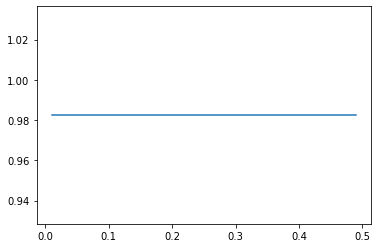

In [84]:
plt.plot(cs, mean_accs)
plt.show()

The accuracy varies very little among the different parameters we used. We can use a c=0.2, just for the sake of the argument, to calculate the accuracy


In [77]:
LR = LogisticRegression(C=0.2, solver='liblinear').fit(X_train,y_train)
yhat_lr = LR.predict(X_test)

print (classification_report(y_test, yhat_lr))

              precision    recall  f1-score   support

           1       0.71      0.92      0.80     32545
           2       0.52      0.21      0.30     14722
           3       0.00      0.00      0.00       764
           4       0.00      0.00      0.00        80

    accuracy                           0.69     48111
   macro avg       0.31      0.28      0.28     48111
weighted avg       0.64      0.69      0.63     48111



/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


We define here the confusion matrix function.

In [78]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

           1       0.71      0.92      0.80     32545
           2       0.52      0.21      0.30     14722
           3       0.00      0.00      0.00       764
           4       0.00      0.00      0.00        80

    accuracy                           0.69     48111
   macro avg       0.31      0.28      0.28     48111
weighted avg       0.64      0.69      0.63     48111

Confusion matrix, without normalization
[[29974  2571     0     0]
 [11623  3099     0     0]
 [  495   269     0     0]
 [   42    38     0     0]]


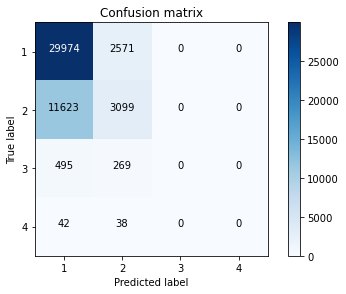

In [79]:
cnf_matrix = confusion_matrix(y_test, yhat_lr)
np.set_printoptions(precision=2)


print (classification_report(y_test, yhat_lr))
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['1','2','3', '4'],normalize= False,  title='Confusion matrix')

In [83]:
f1_score(y_test, yhat_lr, average='weighted') 

0.6346475860163099

In [81]:
precision_score(y_test, yhat_lr, average='weighted')

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6398866774345892

In [82]:
recall_score(y_test, yhat_lr, average = 'weighted')

0.6874311488017293

## DECISION TREE

In [85]:
tree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
tree 

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [86]:
tree.fit(X_train,y_train)
pred_tree = tree.predict(X_test)
print (pred_tree [0:5])
print (y_test [0:5])

[2 1 1 2 2]
[2 1 1 2 2]


In [88]:
depth=10
depths=[]
scores=[]
for i in range (1, depth):
    tree = DecisionTreeClassifier(criterion="entropy", max_depth = i)
    tree.fit(X_train,y_train)
    pred_tree = tree.predict(X_test)
    acc=metrics.accuracy_score(y_test, pred_tree) 
    #std_acc[n-1]=np.std(pred_tree==y_test)/np.sqrt(pred_tree.shape[0])
    
    depths.append(i)
    scores.append(acc)

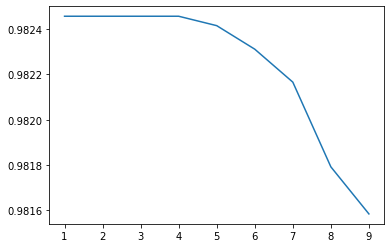

In [89]:
plt.plot(depths, scores)
plt.show()

From a depth of 4, the score is almost constant, we can pick 4 as the depth to build the decision tree model

In [90]:
tree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
tree.fit(X_train,y_train)
pred_tree = tree.predict(X_test)
acc=metrics.accuracy_score(y_test, pred_tree) 
acc

0.9824572343123195

In [91]:
cnf_matrix = confusion_matrix(y_test, pred_tree)
np.set_printoptions(precision=2)


print (classification_report(y_test, pred_tree))
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['1','2','3','4'],normalize= False,  title='Confusion matrix')

              precision    recall  f1-score   support

           1       1.00      1.00      1.00     32545
           2       0.95      1.00      0.97     14722
           3       0.00      0.00      0.00       764
           4       0.00      0.00      0.00        80

    accuracy                           0.98     48111
   macro avg       0.49      0.50      0.49     48111
weighted avg       0.97      0.98      0.97     48111



/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NameError: name 'plot_confusion_matrix' is not defined

<Figure size 432x288 with 0 Axes>

## SVM

In [120]:
#Naive Bayes
nb = GaussianNB(priors=None, var_smoothing=1e-09).fit(X_train,y_train)
nb

NameError: name 'GaussianNB' is not defined

In [ ]:
yhat_svm = clf.predict(X_test)
yhat_svm [0:5]

In [ ]:
cnf_matrix = confusion_matrix(y_test, yhat_svm)
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat_svm))


plt.figure()
plot_confusion_matrix(cnf_matrix,normalize= False, classes = ["1", "2"], title='Confusion matrix')

In [92]:
t0=time.time()
model_rf = RandomForestClassifier(n_estimators=200,random_state=0, n_jobs=-1)
model_rf.fit(X_train,y_train)
print('Time taken :' , time.time()-t0)

Time taken : 7.886478662490845


In [93]:
y_pred = model_rf.predict(X_test)
score_rf = acc=metrics.accuracy_score(y_test, y_pred)

In [94]:
score_rf

0.9817713204880381

In [95]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(model_rf.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')

In [96]:
importances

,importance
feature,
INJURIES,0.835
COLLISIONTYPE,0.037
ST_COLCODE,0.030
Y,0.025
X,0.024
VEHCOUNT,0.018
Hour,0.013
ADDRTYPE,0.008
ROADCOND,0.005


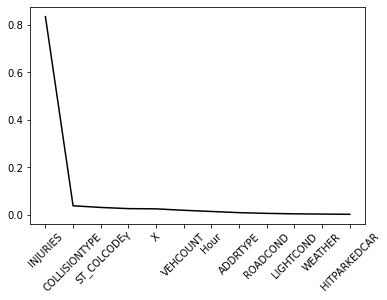

In [97]:
plt.plot(importances, c='black')
plt.xticks(rotation=45)
plt.show()

In [98]:
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

print (classification_report(y_test, y_pred))


plt.figure()
plot_confusion_matrix(cnf_matrix,normalize= False, classes = ["1", "2"], title='Confusion matrix')

              precision    recall  f1-score   support

           1       1.00      1.00      1.00     32545
           2       0.95      1.00      0.97     14722
           3       0.17      0.01      0.02       764
           4       0.20      0.01      0.02        80

    accuracy                           0.98     48111
   macro avg       0.58      0.51      0.50     48111
weighted avg       0.97      0.98      0.97     48111



NameError: name 'plot_confusion_matrix' is not defined

<Figure size 432x288 with 0 Axes>

In [99]:
precision_score(y_test, y_pred, average = 'weighted')

0.9689384572511158

In [100]:
recall_score(y_test, y_pred, average ='weighted')

0.9817713204880381